In [1]:
import sys
sys.path.append('../calibrimbore/')
import calibrimbore as cal 
%matplotlib notebook
import numpy as np

<IPython.core.display.Javascript object>


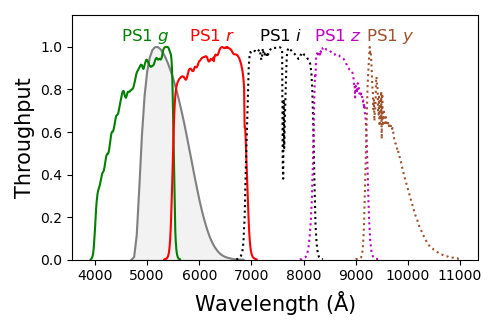

../calibrimbore/calibrimbore.py:167: RuntimeWarning: divide by zero encountered in log10
  comp = -2.5*np.log10(comp) + 25 # default PS1 image zeropoint
/Users/rridden/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
../calibrimbore/calibrimbore.py:167: RuntimeWarning: divide by zero encountered in log10
  comp = -2.5*np.log10(comp) + 25 # default PS1 image zeropoint
/Users/rridden/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


<IPython.core.display.Javascript object>


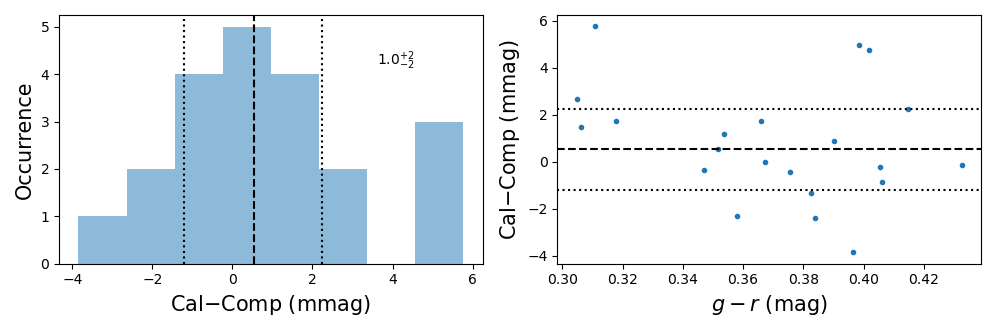

<IPython.core.display.Math object>

In [4]:
filt = '/Users/rridden/Documents/work/code/source_synphot/source_synphot/passbands/Kepler/Kepler_k.dat'
filt = '/Users/rridden/Documents/work/code/source_synphot/source_synphot/passbands/TESS/tess.dat'
filt = '/Users/rridden/Documents/work/code/source_synphot/source_synphot/passbands/keplercam/keplercam_V.dat'
ring = cal.sauron(band=filt,gr_lims=[.3,.5],plot=True)
#ring.syn_calspec_mags()

In [7]:
ring.fit_res

      fun: 3.5259512890264517
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.10276119,  0.        ,  8.68562111,  0.        ,  0.        ,
       -5.15548244])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([8.61437163e-01, 0.00000000e+00, 1.00000000e-10, 0.00000000e+00,
       0.00000000e+00, 3.89713769e-01])

In [4]:
ring.coeff

array([0.00000000e+00, 2.37924324e-01, 3.46185793e-01, 2.80986205e-01,
       1.35954936e-01, 1.09200186e-05])

Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
Warning, 82 of 6560 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 6560 bins contained negative fluxes; they have been set to zero.
Warning, 150 of 6876 bins contained negative fluxes; they have been set to zero.
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
Warning, 94 of 6875 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 30 of 1426 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 1933 bins contained negative fluxes; they have been set to zero.
Warning, 10 of 6254 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 6257 bins contained negative fluxes; they have been set to zero.
Warning, 22 of 6990 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 4861 bins contained negativ

<IPython.core.display.Javascript object>


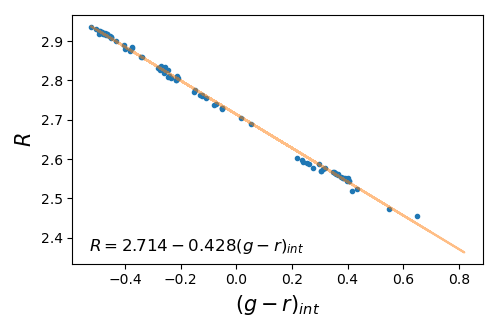

In [7]:
ring.calculate_R(plot=True)

In [ ]:
ring.

In [3]:
ring.fit_comp()

In [4]:
ring.coeff

array([ 0.        ,  0.23754716,  0.35333103,  0.27267768,  0.13748392,
       -0.00140542])

<IPython.core.display.Javascript object>


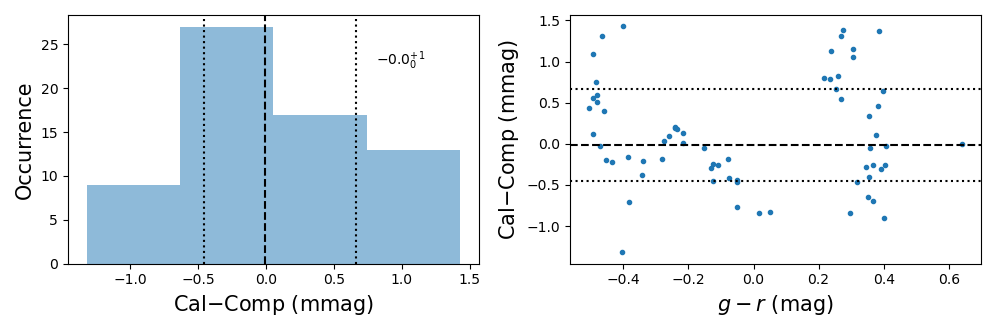

In [5]:
ring.diagnostic_plots()

In [6]:
ring.ps1_overlap

array([0.        , 0.1571635 , 0.27006522, 0.21300593, 0.06523388])

<IPython.core.display.Javascript object>


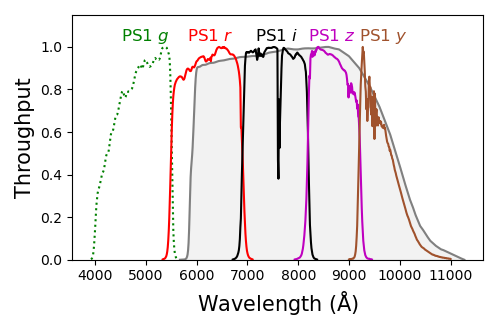